In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import os
import time
from unidecode import unidecode
import warnings
from mplsoccer.pitch import Pitch
import seaborn as sns
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [2]:
match_html_path = r"C:\Users\K Raghunandan\Analyst\Matches\Manchester United 2-0 Manchester City - Premier League 2025_2026 Live.html"
fotmob_matchId = 4813590

def extract_json_from_html(html_path, save_output=False):
    with open(html_path, 'r', encoding='utf-8') as html_file:
        html = html_file.read()

    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for JSON parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save JSON data to txt
        output_file = open(f"{html_path}.txt", "wt", encoding='utf-8')
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict

def get_short_name(full_name):
    if pd.isna(full_name):
        return full_name
    parts = full_name.split()
    if len(parts) == 1:
        return full_name  # No need for short name if there's only one word
    elif len(parts) == 2:
        return parts[0][0] + ". " + parts[1]
    else:
        return parts[0][0] + ". " + parts[1][0] + ". " + " ".join(parts[2:])

json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict = extract_data_from_dict(data)

df = pd.DataFrame(events_dict)
dfp = pd.DataFrame(players_df)
dfp['shortName'] = dfp['name'].apply(get_short_name)

In [3]:
df.columns

Index(['id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
       'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY',
       'relatedEventId', 'relatedPlayerId', 'goalMouthZ', 'goalMouthY',
       'isShot', 'blockedX', 'blockedY', 'cardType', 'isGoal'],
      dtype='object')

In [4]:
dfp.columns

Index(['playerId', 'shirtNo', 'name', 'position', 'height', 'weight', 'age',
       'isFirstEleven', 'isManOfTheMatch', 'field', 'stats',
       'subbedInPlayerId', 'subbedOutPeriod', 'subbedOutExpandedMinute',
       'subbedInPeriod', 'subbedInExpandedMinute', 'subbedOutPlayerId',
       'teamId', 'shortName'],
      dtype='object')

In [5]:
df['type'] = df['type'].str.extract(r"'displayName': '([^']+)")
df['outcomeType'] = df['outcomeType'].str.extract(r"'displayName': '([^']+)")
df['period'] = df['period'].str.extract(r"'displayName': '([^']+)")

In [6]:
df['teamName'] = df['teamId'].map(teams_dict)
team_names = list(teams_dict.values())
opposition_dict = {team_names[i]: team_names[1-i] for i in range(len(team_names))}
df['oppositionTeamName'] = df['teamName'].map(opposition_dict)

In [7]:
df['x'] = df['x']*1.2
df['y'] = df['y']*0.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*0.8
df['goalMouthY'] = df['goalMouthY']*0.8

In [8]:
columns_to_drop = ['height', 'weight', 'age', 'isManOfTheMatch', 'field', 'stats', 
                   'subbedInPlayerId', 'subbedOutPeriod', 
                   'subbedOutExpandedMinute', 'subbedInPeriod', 'subbedInExpandedMinute', 'subbedOutPlayerId', 
                   'teamId']
dfp.drop(columns=columns_to_drop, inplace=True)

In [9]:
df = df.merge(dfp, on='playerId', how='left')

In [10]:
df.columns

Index(['id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
       'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY',
       'relatedEventId', 'relatedPlayerId', 'goalMouthZ', 'goalMouthY',
       'isShot', 'blockedX', 'blockedY', 'cardType', 'isGoal', 'teamName',
       'oppositionTeamName', 'shirtNo', 'name', 'position', 'isFirstEleven',
       'shortName'],
      dtype='object')

In [11]:
df

,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,...,blockedY,cardType,isGoal,teamName,oppositionTeamName,shirtNo,name,position,isFirstEleven,shortName
0,2.889969e+09,3,0,0.0,32,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,Man Utd,Man City,NaN,NaN,NaN,NaN,NaN
1,2.889969e+09,3,0,0.0,167,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,Man City,Man Utd,NaN,NaN,NaN,NaN,NaN
2,2.889969e+09,4,0,0.0,167,59.88,39.84,0,NaN,NaN,...,NaN,NaN,NaN,Man City,Man Utd,20.0,Bernardo Silva,MC,True,B. Silva
3,2.889969e+09,5,0,4.0,167,31.68,43.92,0,NaN,NaN,...,NaN,NaN,NaN,Man City,Man Utd,25.0,Gianluigi Donnarumma,GK,True,G. Donnarumma
4,2.889969e+09,6,0,7.0,167,61.56,18.72,0,NaN,NaN,...,NaN,NaN,NaN,Man City,Man Utd,82.0,Rico Lewis,DR,True,R. Lewis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1534,2.890066e+09,999,96,25.0,167,0.00,0.00,99,NaN,NaN,...,NaN,NaN,NaN,Man City,Man Utd,NaN,NaN,NaN,NaN,NaN
1535,2.890066e+09,670,0,0.0,32,0.00,0.00,9,NaN,NaN,...,NaN,NaN,NaN,Man Utd,Man City,NaN,NaN,NaN,NaN,NaN
1536,2.890066e+09,1000,0,0.0,167,0.00,0.00,9,NaN,NaN,...,NaN,NaN,NaN,Man City,Man Utd,NaN,NaN,NaN,NaN,NaN
1537,2.889948e+09,2,0,0.0,167,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,Man City,Man Utd,NaN,NaN,NaN,NaN,NaN


In [12]:
dfp

,playerId,shirtNo,name,position,isFirstEleven,shortName
0,402184,31,Senne Lammens,GK,True,S. Lammens
1,353418,2,Diogo Dalot,DR,True,D. Dalot
2,340105,6,Lisandro Martínez,DC,True,L. Martínez
3,99487,5,Harry Maguire,DC,True,H. Maguire
4,118244,23,Luke Shaw,DL,True,L. Shaw
5,88526,18,Casemiro,DMC,True,Casemiro
6,460260,37,Kobbie Mainoo,DMC,True,K. Mainoo
7,386634,16,Amad Diallo,AMR,True,A. Diallo
8,123761,8,Bruno Fernandes,AMC,True,B. Fernandes
9,495260,13,Patrick Dorgu,AML,True,P. Dorgu


In [13]:
df = df[
    ((df['x'].notna()) & 
    (df['y'].notna()) & 
    (df['endX'].notna()) & 
    (df['endY'].notna())) | 
    ((df['x'].notna()) & 
    (df['y'].notna()) & 
    (df['goalMouthY'].notna()))
]

In [14]:
df=df.reset_index()

In [15]:
df

,index,id,eventId,minute,second,teamId,x,y,expandedMinute,period,...,blockedY,cardType,isGoal,teamName,oppositionTeamName,shirtNo,name,position,isFirstEleven,shortName
0,2,2.889969e+09,4,0,0.0,167,59.88,39.84,0,NaN,...,NaN,NaN,NaN,Man City,Man Utd,20.0,Bernardo Silva,MC,True,B. Silva
1,3,2.889969e+09,5,0,4.0,167,31.68,43.92,0,NaN,...,NaN,NaN,NaN,Man City,Man Utd,25.0,Gianluigi Donnarumma,GK,True,G. Donnarumma
2,4,2.889969e+09,6,0,7.0,167,61.56,18.72,0,NaN,...,NaN,NaN,NaN,Man City,Man Utd,82.0,Rico Lewis,DR,True,R. Lewis
3,5,2.889969e+09,7,0,9.0,167,72.84,20.24,0,NaN,...,NaN,NaN,NaN,Man City,Man Utd,47.0,Phil Foden,MC,True,P. Foden
4,6,2.889969e+09,8,0,11.0,167,66.24,35.52,0,NaN,...,NaN,NaN,NaN,Man City,Man Utd,16.0,Rodri,DMC,True,Rodri
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086,1524,2.890066e+09,665,96,4.0,32,57.96,8.00,99,NaN,...,NaN,NaN,NaN,Man Utd,Man City,13.0,Patrick Dorgu,AML,True,P. Dorgu
1087,1526,2.890066e+09,992,96,7.0,167,42.00,52.32,99,NaN,...,NaN,NaN,NaN,Man City,Man Utd,45.0,Abdukodir Khusanov,DC,True,A. Khusanov
1088,1527,2.890066e+09,993,96,10.0,167,22.32,42.08,99,NaN,...,NaN,NaN,NaN,Man City,Man Utd,25.0,Gianluigi Donnarumma,GK,True,G. Donnarumma
1089,1528,2.890066e+09,994,96,14.0,167,46.20,56.16,99,NaN,...,NaN,NaN,NaN,Man City,Man Utd,6.0,Nathan Aké,DL,True,N. Aké


In [16]:
df=df[["minute","second","x","y","endX","endY","teamName","shirtNo","position","shortName","goalMouthY","isShot","isGoal"]]

In [17]:
df

,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,0,0.0,59.88,39.84,30.24,44.00,Man City,20.0,MC,B. Silva,NaN,NaN,NaN
1,0,4.0,31.68,43.92,52.80,21.68,Man City,25.0,GK,G. Donnarumma,NaN,NaN,NaN
2,0,7.0,61.56,18.72,72.84,20.24,Man City,82.0,DR,R. Lewis,NaN,NaN,NaN
3,0,9.0,72.84,20.24,66.24,35.52,Man City,47.0,MC,P. Foden,NaN,NaN,NaN
4,0,11.0,66.24,35.52,63.96,49.04,Man City,16.0,DMC,Rodri,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086,96,4.0,57.96,8.00,83.64,33.52,Man Utd,13.0,AML,P. Dorgu,NaN,NaN,NaN
1087,96,7.0,42.00,52.32,20.88,43.04,Man City,45.0,DC,A. Khusanov,NaN,NaN,NaN
1088,96,10.0,22.32,42.08,39.60,52.80,Man City,25.0,GK,G. Donnarumma,NaN,NaN,NaN
1089,96,14.0,46.20,56.16,67.44,72.48,Man City,6.0,DL,N. Aké,NaN,NaN,NaN


In [18]:
df.to_csv('players.csv', index=False)

In [19]:
df.shortName.unique()

array(['B. Silva', 'G. Donnarumma', 'R. Lewis', 'P. Foden', 'Rodri',
       'M. Alleyne', 'N. Aké', 'J. Doku', 'H. Maguire', 'D. Dalot',
       'L. Martínez', 'L. Shaw', 'B. Fernandes', 'P. Dorgu',
       'A. Khusanov', 'K. Mainoo', 'Casemiro', 'B. Mbeumo', 'A. Diallo',
       'A. Semenyo', 'S. Lammens', 'E. Haaland', "N. O'Reilly",
       'R. Cherki', 'M. Cunha', 'T. Reijnders', 'R. Aït-Nouri',
       'M. Ugarte', 'D. Mukasa', 'A. Heaven'], dtype=object)

In [26]:
df_8=df[df["shortName"]=="B. Fernandes"].reset_index()

In [28]:
#Bruno Data
df_8

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,23,2,12.0,90.24,64.00,109.08,76.32,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
1,25,2,47.0,119.40,79.60,116.40,35.20,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
2,63,6,20.0,43.80,48.16,62.64,16.80,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
3,70,7,1.0,76.68,76.00,66.12,74.08,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
4,79,7,47.0,75.12,61.76,103.44,54.00,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
5,95,9,4.0,19.20,13.84,101.40,40.08,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
6,121,12,8.0,40.56,13.20,36.96,2.96,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
7,130,12,58.0,37.92,26.00,45.60,20.72,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
8,146,14,41.0,48.12,47.28,36.48,50.48,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
9,172,17,50.0,47.52,63.28,43.44,54.48,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN


In [29]:
df_18=df[df["shortName"]=="Casemiro"].reset_index()

In [30]:
#Casemiro
df_18

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,42,4,36.0,44.52,59.60,72.36,40.08,Man Utd,18.0,DMC,Casemiro,NaN,NaN,NaN
1,49,5,9.0,62.16,42.72,76.32,46.48,Man Utd,18.0,DMC,Casemiro,NaN,NaN,NaN
2,62,6,18.0,29.76,54.80,45.24,50.64,Man Utd,18.0,DMC,Casemiro,NaN,NaN,NaN
3,127,12,51.0,23.04,29.68,5.28,13.20,Man Utd,18.0,DMC,Casemiro,NaN,NaN,NaN
4,279,25,52.0,11.04,50.48,22.80,65.92,Man Utd,18.0,DMC,Casemiro,NaN,NaN,NaN
5,296,27,41.0,17.28,35.84,14.52,26.88,Man Utd,18.0,DMC,Casemiro,NaN,NaN,NaN
6,320,29,34.0,61.80,41.52,89.88,7.04,Man Utd,18.0,DMC,Casemiro,NaN,NaN,NaN
7,322,29,46.0,87.36,39.20,71.16,66.32,Man Utd,18.0,DMC,Casemiro,NaN,NaN,NaN
8,336,31,16.0,27.84,57.12,39.00,58.40,Man Utd,18.0,DMC,Casemiro,NaN,NaN,NaN
9,340,31,27.0,61.32,40.24,78.00,66.72,Man Utd,18.0,DMC,Casemiro,NaN,NaN,NaN


In [31]:
df_37=df[df["shortName"]=="K. Mainoo"].reset_index()

In [33]:
#Mainoo Data
df_37

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,41,4,34.0,54.48,72.16,45.12,60.00,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
1,52,5,27.0,9.72,51.84,11.40,80.00,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
2,67,6,32.0,86.40,40.32,NaN,NaN,Man Utd,37.0,DMC,K. Mainoo,39.28,True,NaN
3,145,14,40.0,39.60,54.56,48.12,47.28,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
4,149,14,47.0,42.96,55.92,34.92,70.40,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
5,157,15,52.0,67.92,58.80,79.80,58.80,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
6,166,17,33.0,66.60,25.04,62.28,34.00,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
7,173,17,52.0,46.32,57.76,63.72,17.04,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
8,282,26,25.0,56.04,64.16,74.16,59.12,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
9,319,29,31.0,52.80,58.80,50.88,49.68,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN


In [34]:
df_19=df[df["shortName"]=="B. Mbeumo"].reset_index()

In [35]:
#Mbeumo Data
df_19

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,58,6,5.0,43.80,4.96,32.16,10.00,Man Utd,19.0,FW,B. Mbeumo,NaN,NaN,NaN
1,129,12,57.0,49.44,31.36,37.92,26.00,Man Utd,19.0,FW,B. Mbeumo,NaN,NaN,NaN
2,131,13,0.0,50.88,15.84,76.32,5.92,Man Utd,19.0,FW,B. Mbeumo,NaN,NaN,NaN
3,233,22,39.0,53.40,53.28,80.40,78.48,Man Utd,19.0,FW,B. Mbeumo,NaN,NaN,NaN
4,302,27,58.0,108.36,40.32,NaN,NaN,Man Utd,19.0,FW,B. Mbeumo,29.84,True,NaN
5,339,31,25.0,55.44,32.96,56.16,41.04,Man Utd,19.0,FW,B. Mbeumo,NaN,NaN,NaN
6,360,32,29.0,55.08,35.20,72.48,19.68,Man Utd,19.0,FW,B. Mbeumo,NaN,NaN,NaN
7,422,37,40.0,28.68,32.56,37.68,42.64,Man Utd,19.0,FW,B. Mbeumo,NaN,NaN,NaN
8,542,45,34.0,91.68,54.00,81.72,46.00,Man Utd,19.0,FW,B. Mbeumo,NaN,NaN,NaN
9,560,46,31.0,87.60,27.44,78.84,21.12,Man Utd,19.0,FW,B. Mbeumo,NaN,NaN,NaN


In [36]:
df_13=df[df["shortName"]=="P. Dorgu"].reset_index()

In [37]:
#Dorgu Data
df_13

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,24,2,14.0,109.44,77.52,112.32,52.48,Man Utd,13.0,AML,P. Dorgu,NaN,NaN,NaN
1,61,6,16.0,34.68,71.68,30.84,54.72,Man Utd,13.0,AML,P. Dorgu,NaN,NaN,NaN
2,116,11,55.0,42.12,76.00,29.76,71.92,Man Utd,13.0,AML,P. Dorgu,NaN,NaN,NaN
3,144,14,38.0,44.16,73.44,39.60,54.56,Man Utd,13.0,AML,P. Dorgu,NaN,NaN,NaN
4,148,14,46.0,47.04,62.96,42.96,55.92,Man Utd,13.0,AML,P. Dorgu,NaN,NaN,NaN
5,167,17,35.0,66.48,22.08,71.16,6.80,Man Utd,13.0,AML,P. Dorgu,NaN,NaN,NaN
6,211,21,3.0,114.84,50.16,NaN,NaN,Man Utd,13.0,AML,P. Dorgu,40.64,True,NaN
7,234,22,45.0,109.68,69.52,101.76,61.84,Man Utd,13.0,AML,P. Dorgu,NaN,NaN,NaN
8,280,25,55.0,26.40,67.60,44.28,67.76,Man Utd,13.0,AML,P. Dorgu,NaN,NaN,NaN
9,298,27,44.0,24.72,33.52,37.92,30.40,Man Utd,13.0,AML,P. Dorgu,NaN,NaN,NaN


In [39]:
df_10=df[df["shortName"]=="M. Cunha"].reset_index()

In [40]:
#Cunha Data
df_10

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,866,71,6.0,27.84,50.40,35.40,65.76,Man Utd,10.0,Sub,M. Cunha,NaN,NaN,NaN
1,871,71,24.0,33.60,16.80,25.56,19.76,Man Utd,10.0,Sub,M. Cunha,NaN,NaN,NaN
2,878,72,3.0,55.56,11.28,76.68,11.76,Man Utd,10.0,Sub,M. Cunha,NaN,NaN,NaN
3,911,75,17.0,91.20,47.44,89.40,28.08,Man Utd,10.0,Sub,M. Cunha,NaN,NaN,NaN
4,913,75,27.0,116.04,10.48,111.96,41.92,Man Utd,10.0,Sub,M. Cunha,NaN,NaN,NaN
5,959,82,31.0,84.12,5.84,93.48,2.32,Man Utd,10.0,Sub,M. Cunha,NaN,NaN,NaN
6,982,84,44.0,106.20,72.24,93.12,58.88,Man Utd,10.0,Sub,M. Cunha,NaN,NaN,NaN
7,1008,87,51.0,45.84,69.76,53.76,76.96,Man Utd,10.0,Sub,M. Cunha,NaN,NaN,NaN
8,1010,88,7.0,76.44,73.36,61.44,78.16,Man Utd,10.0,Sub,M. Cunha,NaN,NaN,NaN
9,1012,88,9.0,74.76,78.00,66.12,68.00,Man Utd,10.0,Sub,M. Cunha,NaN,NaN,NaN


C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_10872\2536522225.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde=sns.kdeplot(


52


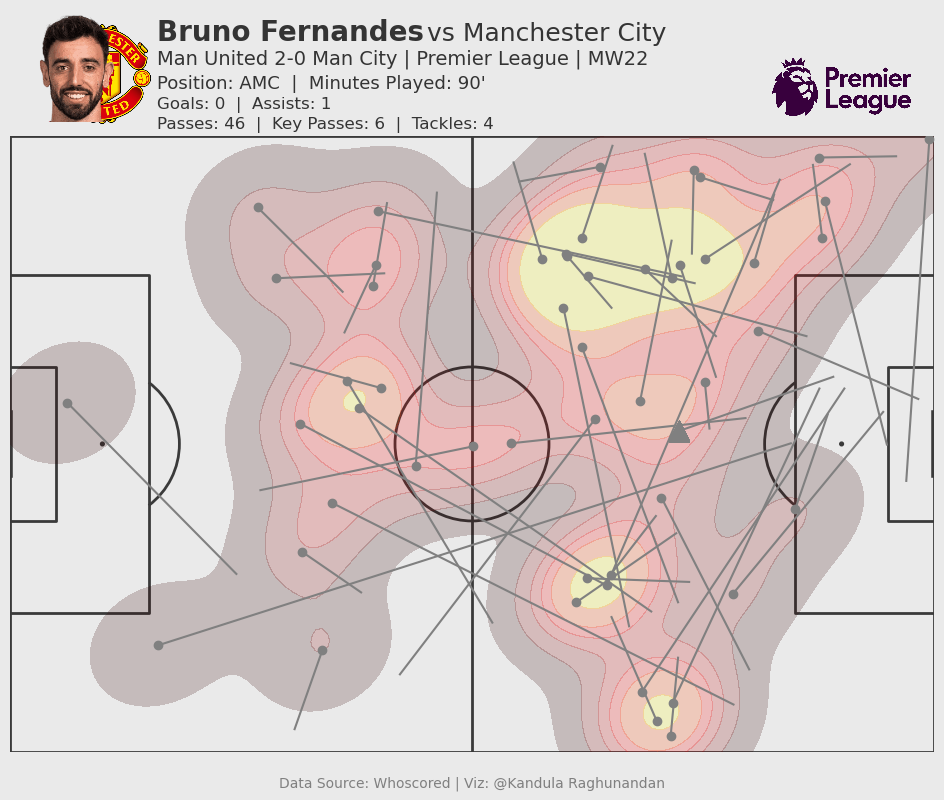

In [59]:
#Bruno Vis
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

kde=sns.kdeplot(
    data=df_8, x="x", y="y",
    shade=True,
    shade_lowest=False,
    alpha=.2,
    bw_adjust=0.5,
    n_levels=7,
    cmap="hot"
)

count=0

for x in range(len(df["x"])):
    #Passes
    if df["shortName"][x]=="B. Fernandes":
        plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="#808080")
        plt.scatter(df["x"][x],df["y"][x],color="#808080")
        count=count+1

    #Shots
    if (df["shortName"][x]=="B. Fernandes") & (df["isShot"][x]==True):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="red")
        plt.scatter(df["x"][x],df["y"][x],color="red")
        
    #Assists
    if (df["isGoal"][821]==True):
        plt.scatter(df["x"][820],df["y"][820],color="#808080",marker="^",s=200)
        #print(x)
        
    #Goals
    if (df["isGoal"][x]==True) & (df["shortName"][x]=="B. Fernandes"):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="Green")
        plt.scatter(df["x"][x],df["y"][x],color="Green",marker="*",s=200)

print(count)

fig.text(0.25, 1, "Bruno Fernandes", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.475,1,"vs Manchester City", fontsize = 18, color="#343434")
fig.text(0.25, 0.97, "Man United 2-0 Man City | Premier League | MW22", 
         fontsize=14, color='#343434')
fig.text(0.25, 0.94, "Position: AMC  |  Minutes Played: 90'", 
         fontsize=13, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
player_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Players/Bruno Fernandes.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.1))
add_logo(ax, player_logo, zoom=0.4, xy=(0.072, 1.11))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.08))

fig.text(0.25, 0.915, "Goals: 0  |  Assists: 1", fontsize=12, color='#343434')
fig.text(0.25, 0.89, "Passes: 46  |  Key Passes: 6  |  Tackles: 4", fontsize=12, color='#343434')

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Manchester United 2-0 Manchester City - Premier League 2025_2026 Live_files\New folder\Bruno.jpg",bbox_inches='tight')

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_10872\1981547067.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde=sns.kdeplot(


34


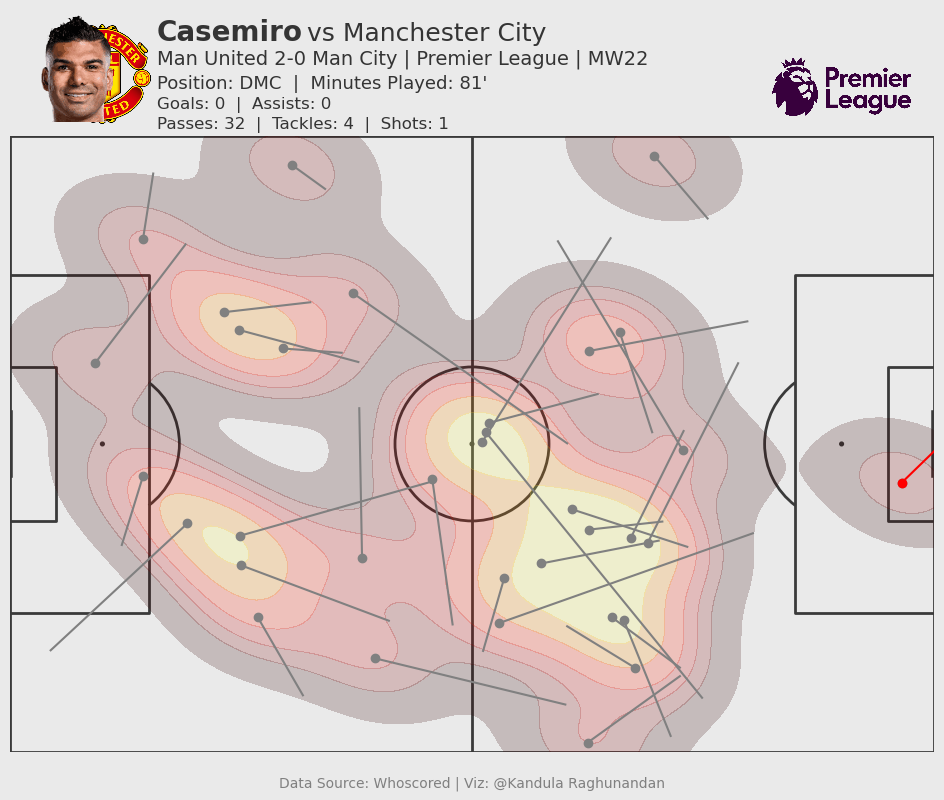

In [65]:
#Casemiro Vis
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

kde=sns.kdeplot(
    data=df_18, x="x", y="y",
    shade=True,
    shade_lowest=False,
    alpha=.2,
    bw_adjust=0.5,
    n_levels=7,
    cmap="hot"
)

count=0

for x in range(len(df["x"])):
    #Passes
    if df["shortName"][x]=="Casemiro":
        plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="#808080")
        plt.scatter(df["x"][x],df["y"][x],color="#808080")
        count=count+1

    #Shots
    if (df["shortName"][x]=="Casemiro") & (df["isShot"][x]==True):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="red")
        plt.scatter(df["x"][x],df["y"][x],color="red")
        
    #Assists
    #if (df["isGoal"][821]==True):
        #plt.scatter(df["x"][820],df["y"][820],color="#808080",marker="^",s=200)
        #print(x)
        
    #Goals
    if (df["isGoal"][x]==True) & (df["shortName"][x]=="Casemiro"):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="Green")
        plt.scatter(df["x"][x],df["y"][x],color="Green",marker="*",s=200)

print(count)

fig.text(0.25, 1, "Casemiro", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.375,1,"vs Manchester City", fontsize = 18, color="#343434")
fig.text(0.25, 0.97, "Man United 2-0 Man City | Premier League | MW22", 
         fontsize=14, color='#343434')
fig.text(0.25, 0.94, "Position: DMC  |  Minutes Played: 81'", 
         fontsize=13, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
player_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Players/Casemiro.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.1))
add_logo(ax, player_logo, zoom=0.4, xy=(0.072, 1.11))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.08))

fig.text(0.25, 0.915, "Goals: 0  |  Assists: 0", fontsize=12, color='#343434')
fig.text(0.25, 0.89, "Passes: 32  |  Tackles: 4  |  Shots: 1", fontsize=12, color='#343434')

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Manchester United 2-0 Manchester City - Premier League 2025_2026 Live_files\New folder\Case.jpg",bbox_inches='tight')

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_10872\886148725.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde=sns.kdeplot(


18


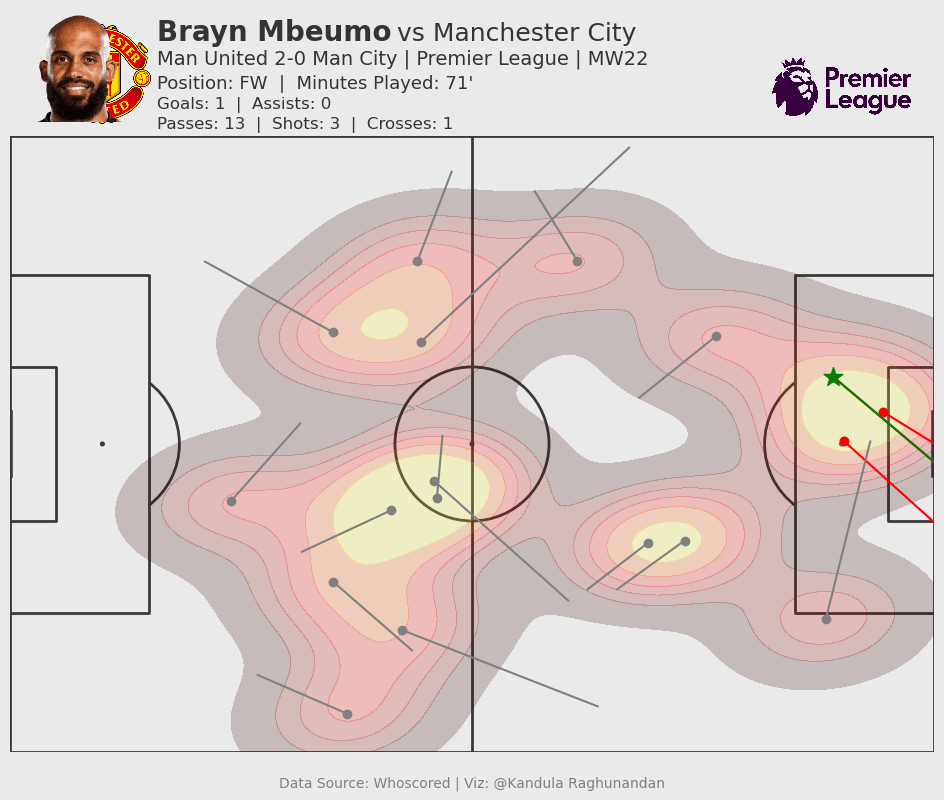

In [66]:
#Mbeumo Vis
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

kde=sns.kdeplot(
    data=df_19, x="x", y="y",
    shade=True,
    shade_lowest=False,
    alpha=.2,
    bw_adjust=0.5,
    n_levels=7,
    cmap="hot"
)

count=0

for x in range(len(df["x"])):
    #Passes
    if df["shortName"][x]=="B. Mbeumo":
        plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="#808080")
        plt.scatter(df["x"][x],df["y"][x],color="#808080")
        count=count+1

    #Shots
    if (df["shortName"][x]=="B. Mbeumo") & (df["isShot"][x]==True):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="red")
        plt.scatter(df["x"][x],df["y"][x],color="red")
        
    #Assists
    #if (df["isGoal"][821]==True):
        #plt.scatter(df["x"][820],df["y"][820],color="#808080",marker="^",s=200)
        #print(x)
        
    #Goals
    if (df["isGoal"][x]==True) & (df["shortName"][x]=="B. Mbeumo"):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="Green")
        plt.scatter(df["x"][x],df["y"][x],color="Green",marker="*",s=200)

print(count)

fig.text(0.25, 1, "Brayn Mbeumo", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.45,1,"vs Manchester City", fontsize = 18, color="#343434")
fig.text(0.25, 0.97, "Man United 2-0 Man City | Premier League | MW22", 
         fontsize=14, color='#343434')
fig.text(0.25, 0.94, "Position: FW  |  Minutes Played: 71'", 
         fontsize=13, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
player_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Players/Mbeumo.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.1))
add_logo(ax, player_logo, zoom=0.4, xy=(0.072, 1.11))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.08))

fig.text(0.25, 0.915, "Goals: 1  |  Assists: 0", fontsize=12, color='#343434')
fig.text(0.25, 0.89, "Passes: 13  |  Shots: 3  |  Crosses: 1", fontsize=12, color='#343434')

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Manchester United 2-0 Manchester City - Premier League 2025_2026 Live_files\New folder\Mbeumo.jpg",bbox_inches='tight')

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_10872\3352981156.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde=sns.kdeplot(


34


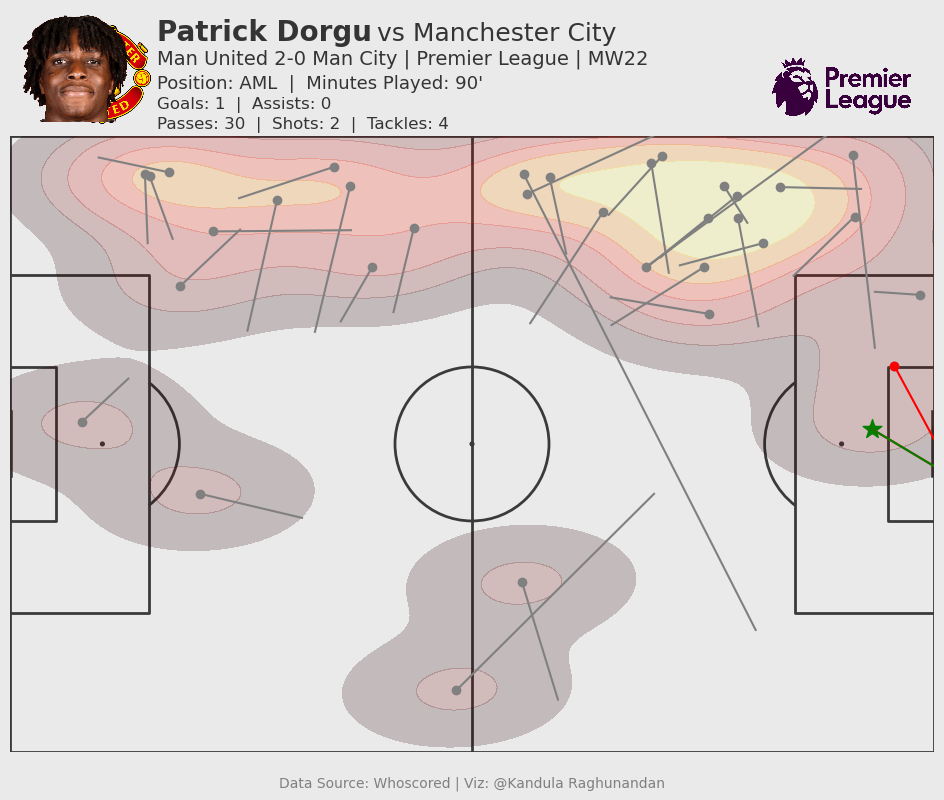

In [73]:
#Dorgu Vis
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

kde=sns.kdeplot(
    data=df_13, x="x", y="y",
    shade=True,
    shade_lowest=False,
    alpha=.2,
    bw_adjust=0.5,
    n_levels=7,
    cmap="hot"
)

count=0

for x in range(len(df["x"])):
    #Passes
    if df["shortName"][x]=="P. Dorgu":
        plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="#808080")
        plt.scatter(df["x"][x],df["y"][x],color="#808080")
        count=count+1

    #Shots
    if (df["shortName"][x]=="P. Dorgu") & (df["isShot"][x]==True):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="red")
        plt.scatter(df["x"][x],df["y"][x],color="red")
        
    #Assists
    #if (df["isGoal"][821]==True):
        #plt.scatter(df["x"][820],df["y"][820],color="#808080",marker="^",s=200)
        #print(x)
        
    #Goals
    if (df["isGoal"][x]==True) & (df["shortName"][x]=="P. Dorgu"):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="Green")
        plt.scatter(df["x"][x],df["y"][x],color="Green",marker="*",s=200)

print(count)

fig.text(0.25, 1, "Patrick Dorgu", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.433,1,"vs Manchester City", fontsize = 18, color="#343434")
fig.text(0.25, 0.97, "Man United 2-0 Man City | Premier League | MW22", 
         fontsize=14, color='#343434')
fig.text(0.25, 0.94, "Position: AML  |  Minutes Played: 90'", 
         fontsize=13, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
player_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Players/Dorgu.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.1))
add_logo(ax, player_logo, zoom=0.4, xy=(0.072, 1.11))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.08))

fig.text(0.25, 0.915, "Goals: 1  |  Assists: 0", fontsize=12, color='#343434')
fig.text(0.25, 0.89, "Passes: 30  |  Shots: 2  |  Tackles: 4", fontsize=12, color='#343434')

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Manchester United 2-0 Manchester City - Premier League 2025_2026 Live_files\New folder\Dorgu.jpg",bbox_inches='tight')

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_10872\3694097985.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde=sns.kdeplot(


38


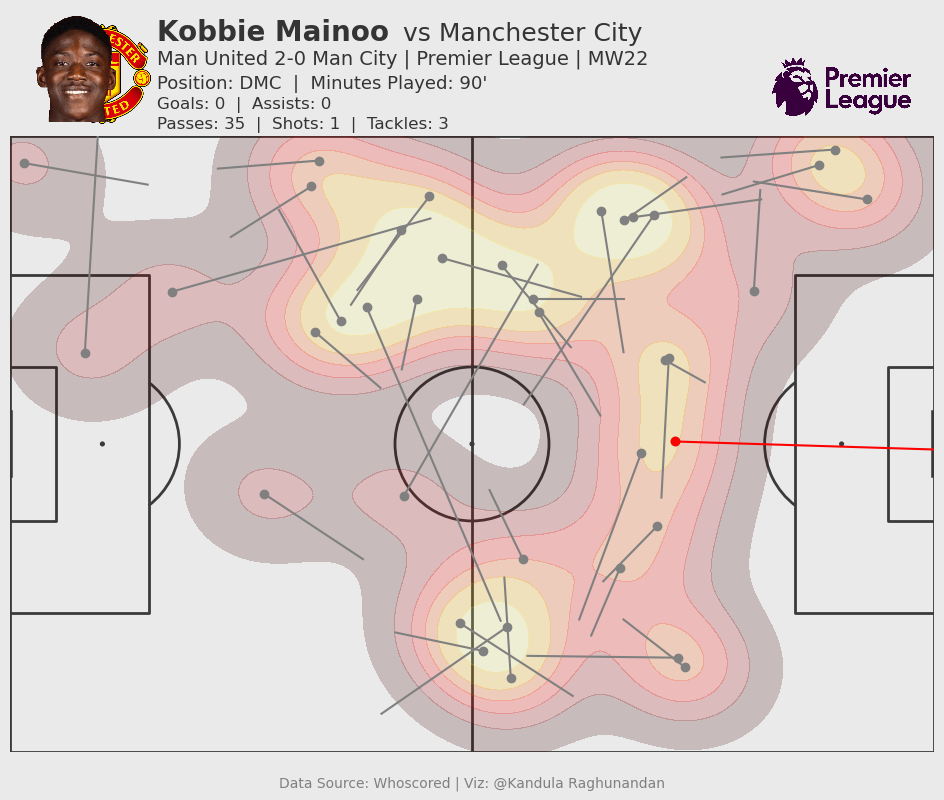

In [74]:
#Mainoo Vis
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

kde=sns.kdeplot(
    data=df_37, x="x", y="y",
    shade=True,
    shade_lowest=False,
    alpha=.2,
    bw_adjust=0.5,
    n_levels=7,
    cmap="hot"
)

count=0

for x in range(len(df["x"])):
    #Passes
    if df["shortName"][x]=="K. Mainoo":
        plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="#808080")
        plt.scatter(df["x"][x],df["y"][x],color="#808080")
        count=count+1

    #Shots
    if (df["shortName"][x]=="K. Mainoo") & (df["isShot"][x]==True):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="red")
        plt.scatter(df["x"][x],df["y"][x],color="red")
        
    #Assists
    #if (df["isGoal"][821]==True):
        #plt.scatter(df["x"][820],df["y"][820],color="#808080",marker="^",s=200)
        #print(x)
        
    #Goals
    if (df["isGoal"][x]==True) & (df["shortName"][x]=="K. Mainoo"):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="Green")
        plt.scatter(df["x"][x],df["y"][x],color="Green",marker="*",s=200)

print(count)

fig.text(0.25, 1, "Kobbie Mainoo", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.455,1,"vs Manchester City", fontsize = 18, color="#343434")
fig.text(0.25, 0.97, "Man United 2-0 Man City | Premier League | MW22", 
         fontsize=14, color='#343434')
fig.text(0.25, 0.94, "Position: DMC  |  Minutes Played: 90'", 
         fontsize=13, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
player_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Players/Mainoo.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.1))
add_logo(ax, player_logo, zoom=0.4, xy=(0.072, 1.11))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.08))

fig.text(0.25, 0.915, "Goals: 0  |  Assists: 0", fontsize=12, color='#343434')
fig.text(0.25, 0.89, "Passes: 35  |  Shots: 1  |  Tackles: 3", fontsize=12, color='#343434')

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Manchester United 2-0 Manchester City - Premier League 2025_2026 Live_files\New folder\Mainoo.jpg",bbox_inches='tight')

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_10872\2755057516.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde=sns.kdeplot(


13


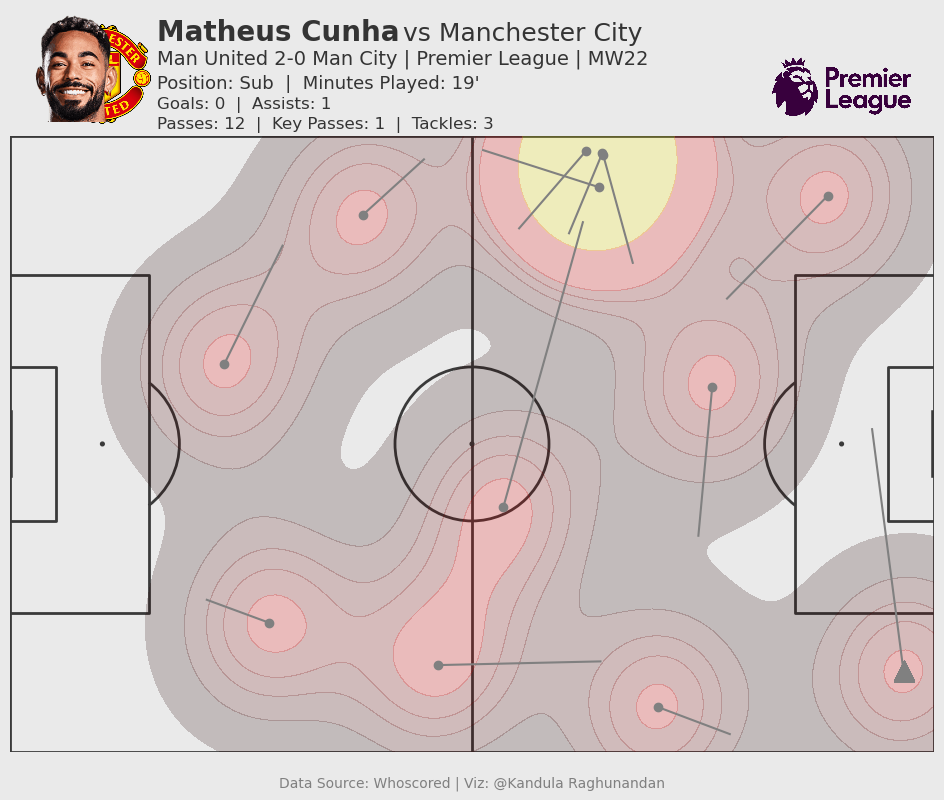

In [78]:
#Cunha Vis
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

kde=sns.kdeplot(
    data=df_10, x="x", y="y",
    shade=True,
    shade_lowest=False,
    alpha=.2,
    bw_adjust=0.5,
    n_levels=7,
    cmap="hot"
)

count=0

for x in range(len(df["x"])):
    #Passes
    if df["shortName"][x]=="M. Cunha":
        plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="#808080")
        plt.scatter(df["x"][x],df["y"][x],color="#808080")
        count=count+1

    #Shots
    if (df["shortName"][x]=="M. Cunha") & (df["isShot"][x]==True):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="red")
        plt.scatter(df["x"][x],df["y"][x],color="red")
        
    #Assists
    if (df["isGoal"][914]==True):
        plt.scatter(df["x"][913],df["y"][913],color="#808080",marker="^",s=200)
        #print(x)
        
    #Goals
    if (df["isGoal"][x]==True) & (df["shortName"][x]=="M. Cunha"):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="Green")
        plt.scatter(df["x"][x],df["y"][x],color="Green",marker="*",s=200)

print(count)

fig.text(0.25, 1, "Matheus Cunha", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.455,1,"vs Manchester City", fontsize = 18, color="#343434")
fig.text(0.25, 0.97, "Man United 2-0 Man City | Premier League | MW22", 
         fontsize=14, color='#343434')
fig.text(0.25, 0.94, "Position: Sub  |  Minutes Played: 19'", 
         fontsize=13, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
player_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Players/Cunha.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.1))
add_logo(ax, player_logo, zoom=0.4, xy=(0.072, 1.11))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.08))

fig.text(0.25, 0.915, "Goals: 0  |  Assists: 1", fontsize=12, color='#343434')
fig.text(0.25, 0.89, "Passes: 12  |  Key Passes: 1  |  Tackles: 3", fontsize=12, color='#343434')

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Manchester United 2-0 Manchester City - Premier League 2025_2026 Live_files\New folder\Cunha.jpg",bbox_inches='tight')